<a href="https://colab.research.google.com/github/TTD-JPO/TDD-project/blob/petra/pw_TweetDisasterDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libs & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta, time

In [2]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [3]:
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, plot_confusion_matrix

from sklearn.naive_bayes import CategoricalNB, MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[Link to data (csv) @google drive](https://drive.google.com/file/d/1QPragNh_wYQVsXQvds8sqjDMfzARD638/view?usp=sharing)


In [5]:
url = 'https://raw.githubusercontent.com/TTD-JPO/TDD-project/main/disaster_tweets.csv'
disaster_tweets = pd.read_csv(url, encoding='latin-1')

##add Petra

In [6]:
#zum block mit nlp---- import re.....
from wordcloud import STOPWORDS
import string

end___Petra

## Evaluate data

In [7]:
disaster_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
print( "absolute number of disaster indicated messages:", disaster_tweets.target.sum() )
print( f"relative number of disaster indicated messages: {disaster_tweets.target.sum() / disaster_tweets.shape[0] :0.3f}" )

absolute number of disaster indicated messages: 3271
relative number of disaster indicated messages: 0.430


In [9]:
keys      = list(disaster_tweets.keyword.unique() )
locations = list(disaster_tweets.location.unique() )
print(f'len_keys: {len(keys)}\tlen_locations: {len(locations)}')

len_keys: 222	len_locations: 3342


In [10]:
disaster_tweets.groupby('keyword').target.count().sort_values(ascending=False)

keyword
fatalities               45
deluge                   42
armageddon               42
body%20bags              41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: target, Length: 221, dtype: int64

In [11]:
disaster_tweets.groupby('location').target.count().sort_values(ascending=False)

location
USA                            104
New York                        71
United States                   50
London                          45
Canada                          29
                              ... 
Republica Dominicana             1
Republic of the Philippines      1
Regalo Island                    1
Redondo Beach, CA                1
                                 1
Name: target, Length: 3341, dtype: int64

In [12]:
display( f"relative number of keyword   messages: {disaster_tweets.keyword.nunique()  / disaster_tweets.shape[0] :0.3f}" )
display( f"relative number of location  messages: {disaster_tweets.location.nunique() / disaster_tweets.shape[0] :0.3f}" )

'relative number of keyword   messages: 0.029'

'relative number of location  messages: 0.439'

In [13]:
### we might do these steps later after having processed the text :)
#dt = disaster_tweets.copy()

## Visualization of data (of)

In [14]:
df = disaster_tweets

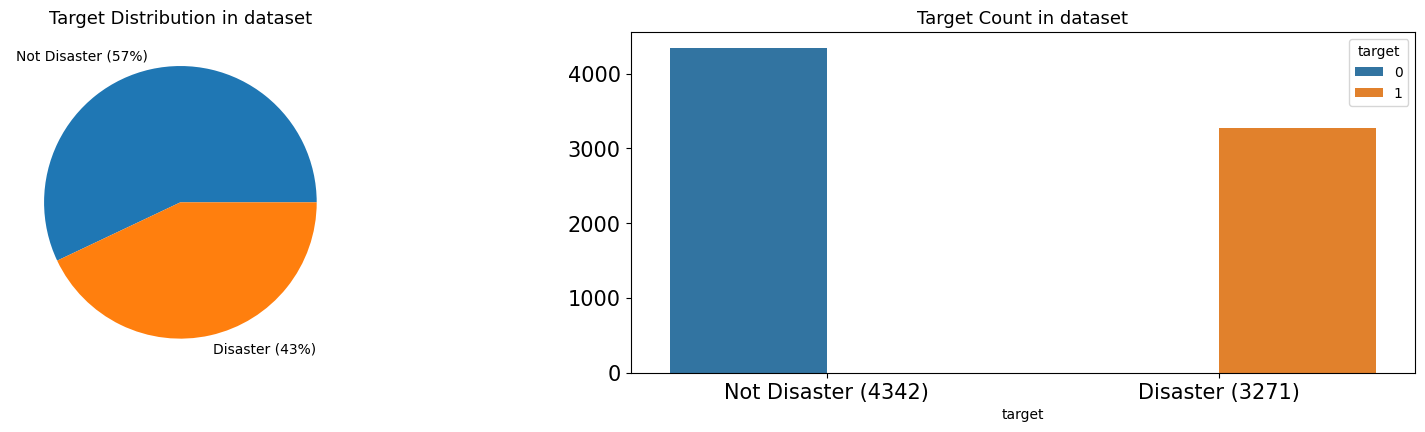

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=df['target'], hue=df['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in dataset', fontsize=13)
axes[1].set_title('Target Count in dataset', fontsize=13)

plt.show()

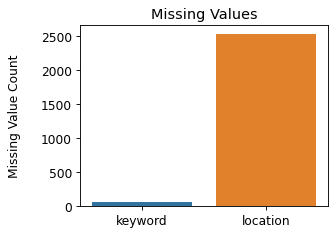

In [16]:
missing_cols = ['keyword', 'location']

plt.figure(figsize=(4, 3), dpi=80)

sns.barplot(x=disaster_tweets[missing_cols].isna().sum().index, y=disaster_tweets[missing_cols].isna().sum().values)

plt.ylabel('Missing Value Count', size=11, labelpad=18)
plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=11)

plt.title('Missing Values', fontsize=13)

plt.show()

# Cleaning of data 
- df deaster tweets - 'dtt_clean'

##add petra

In [17]:
dtt_clean = disaster_tweets.copy()

hier neu Teil 1 helperfunktion für clean text

In [18]:
def clean_text(text):
  # get rid of all unwanted punctuation and digits
  text = text.replace("´", "'")

  digi_punct = "[^a-zA-Z' ]"
  text = re.sub(digi_punct, " ", text)
  text = " ".join(text.split())
  text = text.lower()

  return text

def my_df_text_mining(df, col):
  lemmatizer = WordNetLemmatizer()
  my_stopwords = stopwords.words("english")
  
  df["_no_stopwords"] = df[col].apply(             lambda texxt: " ".join([word for word in clean_text(texxt).split() if word not in my_stopwords]))
  df[col]             = df["_no_stopwords"].apply( lambda texxt: " ".join([lemmatizer.lemmatize(word) for word in texxt.split()]) )

  return df.drop(["_no_stopwords"], axis=1)

In [19]:
dtt_clean = my_df_text_mining(dtt_clean, 'text')

In [20]:
dtt_clean.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,resident asked 'shelter place' notified office...,1


end--petra

## clean NaN

##löschen

In [21]:
#dtt_clean = disaster_tweets.copy()

end__löschen

In [22]:
missing_cols = ['keyword', 'location']
for col in  missing_cols:
    dtt_clean[col] = dtt_clean[col].fillna(f'no_{col}')

In [53]:
dtt_clean.head(2)

,id,keyword,location,text,target
0,1,no_keyword,no_location,deed reason earthquake may allah forgive u,1
1,4,no_keyword,no_location,forest fire near la ronge sask canada,1


# Analizing tweet < text >
- NLP keyword, localization 

### trail ... (pw)


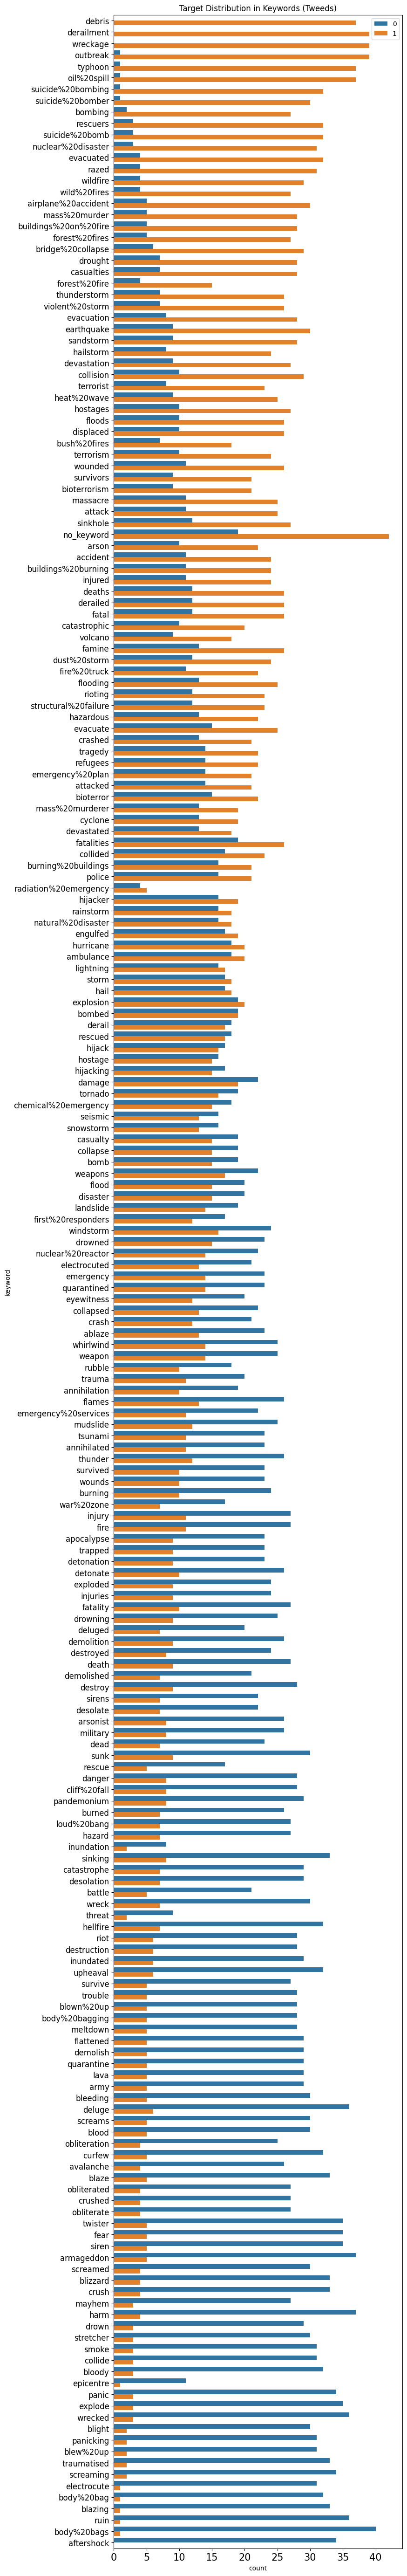

In [30]:
dtt_clean['target_mean'] = dtt_clean.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=dtt_clean.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=dtt_clean.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

dtt_clean.drop(columns=['target_mean'], inplace=True)

In [36]:
import string

+ word_count number of words in text
+ unique_word_count number of unique words in text
+ stop_word_count number of stop words in text
+ url_count number of urls in text
+ mean_word_length average character count in words
+ char_count number of characters in text
+ punctuation_count number of punctuations in text
+ hashtag_count number of hashtags (#) in text
+ mention_count number of mentions (@) in text

In [37]:
# word_count
dtt_clean['word_count'] = dtt_clean['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
dtt_clean['unique_word_count'] = dtt_clean['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
dtt_clean['stop_word_count'] = dtt_clean['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
dtt_clean['url_count'] = dtt_clean['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
dtt_clean['mean_word_length'] = dtt_clean['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
dtt_clean['char_count'] = dtt_clean['text'].apply(lambda x: len(str(x)))

# punctuation_count
dtt_clean['punctuation_count'] = dtt_clean['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))


# hashtag_count
dtt_clean['hashtag_count'] = dtt_clean['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
dtt_clean['mention_count'] = dtt_clean['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [39]:
dtt_clean.head(2)

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,0,4.384615,69,1,1,0
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,7,7,0,0,4.571429,38,1,0,0


In [ ]:
len(keys), len(locations)

(222, 3342)

In [25]:
no_target_ = dtt_clean[ dtt_clean.target == 0]
target_    = dtt_clean[ dtt_clean.target == 1]

hier kann noch rein Vergleich der Wortlängen .... von target == 1 mit target == 2

-- (PW)

# ...

#petra: bitte helperfunction teilen....
ab spacy kann hier bleiben

## Helper function

In [ ]:
def clean_text(text):
  # get rid of all unwanted punctuation and digits
  text = text.replace("´", "'")

  digi_punct = "[^a-zA-Z' ]"
  text = re.sub(digi_punct, " ", text)
  text = " ".join(text.split())
  text = text.lower()

  return text

def my_df_text_mining(df, col):
  lemmatizer = WordNetLemmatizer()
  my_stopwords = stopwords.words("english")
  
  df["_no_stopwords"] = df[col].apply(             lambda texxt: " ".join([word for word in clean_text(texxt).split() if word not in my_stopwords]))
  df[col]             = df["_no_stopwords"].apply( lambda texxt: " ".join([lemmatizer.lemmatize(word) for word in texxt.split()]) )

  return df.drop(["_no_stopwords"], axis=1)

################################
def my_df_spacy_locgpe(df, col):  
  df["loc_gpe"] = df[col].apply( lambda texxt: " ".join([ str(ent) for ent in nlp(texxt).ents  if ((ent.label_ =='LOC') | (ent.label_ =='GPE'))]) )
  return df

def my_df_spacy_date_time(df, col):
  df["date_time"] = df[col].apply( lambda texxt: " ".join([ str(ent) for ent in nlp(texxt).ents  if ((ent.label_ =='DATE') | (ent.label_ =='TIME'))]) )
  return df

def my_df_spacy_fac(df, col):
  df["FAC"] = df[col].apply( lambda texxt: " ".join([ str(ent) for ent in nlp(texxt).ents  if (ent.label_ =='FAC') ]) )
  return df
################################

def spcy_test(text):
  displacy.render(nlp(text), style='ent', jupyter=True)

def spcy_test2(text):
  text = ",".join(text.split())
  displacy.render(nlp(text), style='ent', jupyter=True)

################################

## jedi playground

In [ ]:
test_text = "Barbados #Bridgetown JAMAICA Â\x89Ã\x9bÃ\x92 Two cars set ablaze: SANTA CRUZ Â\x89Ã\x9bÃ\x93 Head of the St Elizabeth Police Superintende"
test_text = 'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding'
spcy_test(test_text)
spcy_test2(test_text)

In [ ]:
test_df = disaster_tweets[40:100]
list(test_df.text)

In [ ]:
df1 = my_df_spacy_locgpe(test_df.copy(), 'text')
df1

In [ ]:
df2 = my_df_spacy_fac   (df1.copy(), 'text')
df2

# Evaluationg Basic modeling

In [ ]:
df    = disaster_tweets.copy()

In [ ]:
#tfidf_v = TfidfVectorizer(ngram_range=(1, 2))
#tfidf_bow = tfidf_v.fit_transform(df["_lemmatized"])   # FIT and transform to learn
### ??? wo wird das denn weiterverwendet ???

In [ ]:
#tfidf_v.transform(no_df['_lemmatized'])  # only transformation!!!

## Train-Test-Split

In [ ]:
X_train, X_test,\
y_train, y_test =\
 train_test_split(df["text"],
                  df["target"],
                  test_size=0.2,
                  random_state=314159,
                  stratify=df["target"])

##pipline Tfidf, MultinomialNB

In [ ]:
#### naive bayes 
pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), MultinomialNB())

#display( cross_val_score(pipeMNB, X_train, y_train).mean() )

pipeMNB.fit(X_train, y_train)

plot_confusion_matrix(pipeMNB, X_test, y_test, values_format="0.3f", normalize='true', cmap="RdYlGn")
plt.title(f"best accuracy: { accuracy_score(y_test, pipeMNB.predict(X_test)):0.3f}")
plt.show()

In [ ]:
df = disaster_tweets.copy()
#### copy for trials

X_train, X_test,\
y_train, y_test =\
 train_test_split(df["text"],
                  df["target"],
                  test_size=0.2,
                  random_state=314159,
                  stratify=df["target"])


#### naive bayes 
pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), MultinomialNB())

#display( cross_val_score(pipeMNB, X_train, y_train).mean() )

pipeMNB.fit(X_train, y_train)

plot_confusion_matrix(pipeMNB, X_test, y_test, values_format="0.3f", normalize='true', cmap="RdYlGn")
plt.title(f"best accuracy: { accuracy_score(y_test, pipeMNB.predict(X_test)):0.3f}")
plt.show()

# Evaluation extended Modeling (weitere Spalten)

# Final Model

In [ ]:
# Performance